## Using Scikit-Learn and NLTK to build a Naive Bayes Classifier that identifies subtweets

#### In all tables, assume:
* "➊" represents a single hashtag
* "➋" represents a single URL
* "➌" represents a single mention of username (e.g. "@noah")

#### Import libraries

In [1]:
%matplotlib inline

In [2]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from os.path import basename, splitext
from random import choice, sample
from nltk.corpus import stopwords
from string import punctuation
from pprint import pprint
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import scipy.stats
import itertools
import enchant
import nltk
import json
import re

#### Set up some regex patterns

In [3]:
hashtags_pattern = re.compile(r'(\#[a-zA-Z0-9]+)')

In [4]:
urls_pattern = re.compile(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?\xab\xbb\u201c\u201d\u2018\u2019]))')

In [5]:
at_mentions_pattern = re.compile(r'(?<=^|(?<=[^a-zA-Z0-9-\.]))@([A-Za-z0-9_]+)')

#### Prepare English dictionary for language detection

In [6]:
english_dict = enchant.Dict("en_US")

#### Use NLTK's tokenizer instead of Scikit's

In [7]:
tokenizer = nltk.casual.TweetTokenizer(preserve_case=False, reduce_len=True)

#### Prepare for viewing long text in CSVs and ones with really big and small numbers

In [8]:
pd.set_option("max_colwidth", 1000)

In [9]:
pd.options.display.float_format = "{:.4f}".format

#### Load the two data files
#### Only use tweets with at least 50% English words
#### Also, make the mentions of usernames, URLs, and hashtags generic

In [10]:
def load_data(filename, threshold=0.5):
    data = [(hashtags_pattern.sub("➊", 
             urls_pattern.sub("➋", 
             at_mentions_pattern.sub("➌", 
             t["tweet_data"]["full_text"])))
             .replace("\u2018", "'")
             .replace("\u2019", "'")
             .replace("\u201c", "\"")
             .replace("\u201d", "\"")
             .replace("&quot;", "\"")
             .replace("&amp;", "&")
             .replace("&gt;", ">")
             .replace("&lt;", "<")) 
            for t in json.load(open(filename)) 
            if t["tweet_data"]["user"]["lang"] == "en" 
            and t["reply"]["user"]["lang"] == "en"]
    new_data = []
    for tweet in data:
        tokens = tokenizer.tokenize(tweet)
        english_tokens = [english_dict.check(token) for token in tokens]
        percent_english_words = sum(english_tokens)/len(english_tokens)
        if percent_english_words >= threshold:
            new_data.append(tweet)
    return new_data

In [11]:
subtweets_data = load_data("../data/other_data/subtweets.json")

In [12]:
non_subtweets_data = load_data("../data/other_data/non_subtweets.json")

#### Remove tweets which are present in both datasets

In [13]:
subtweets_data = [tweet for tweet in subtweets_data if tweet not in non_subtweets_data]

In [14]:
non_subtweets_data = [tweet for tweet in non_subtweets_data if tweet not in subtweets_data]

#### Show examples

In [15]:
print("Subtweets dataset example:")
print(choice(subtweets_data))

Subtweets dataset example:
When you're gettin yelled at but you keep your mouth shut bc explaining Yourself counts as talking back apparently ➋


In [16]:
print("Non-subtweets dataset example:")
print(choice(non_subtweets_data))

Non-subtweets dataset example:
i am: lonely


#### Find the length of the smaller dataset

In [17]:
smallest_length = len(min([subtweets_data, non_subtweets_data], key=len))

#### Cut both down to be the same length

In [18]:
subtweets_data = sample(subtweets_data, smallest_length)

In [19]:
non_subtweets_data = sample(non_subtweets_data, smallest_length)

In [20]:
print("Smallest dataset length: {}".format(len(subtweets_data)))

Smallest dataset length: 11043


#### Prepare data for training

In [21]:
subtweets_data = [(tweet, "subtweet") for tweet in subtweets_data]

In [22]:
non_subtweets_data = [(tweet, "non-subtweet") for tweet in non_subtweets_data]

#### Combine them

In [23]:
training_data = subtweets_data + non_subtweets_data

#### Create custom stop words to include generic usernames, URLs, and hashtags, as well as common English first names

In [24]:
names_lower = set([name.lower() for name in open("../data/other_data/first_names.txt").read().split("\n")])

In [25]:
generic_tokens = {"➊", "➋", "➌"}

In [26]:
stop_words = text.ENGLISH_STOP_WORDS | names_lower | generic_tokens

#### Build the pipeline

In [27]:
sentiment_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                   ngram_range=(1, 3), 
                                   stop_words=stop_words)),
    ("classifier", MultinomialNB())
])

#### K-Folds splits up and separates out 10 training and test sets from the data, from which the classifier is trained and the confusion matrix and classification reports are updated

In [28]:
def confusion_matrices(training_data, num_folds=10):
    text_training_data = np.array([row[0] for row in training_data])
    class_training_data = np.array([row[1] for row in training_data])
    kf = KFold(n_splits=num_folds, random_state=42, shuffle=True)
    
    cnf_matrix_test = np.zeros((2, 2), dtype=int)
    cnf_matrix_train = np.zeros((2, 2), dtype=int)
    
    test_reports = []
    train_reports = []
    
    test_accuracies = []
    train_accuracies = []
    for i, (train_index, test_index) in enumerate(kf.split(text_training_data)):

        text_train, text_test = text_training_data[train_index], text_training_data[test_index]
        class_train, class_test = class_training_data[train_index], class_training_data[test_index]

        sentiment_pipeline.fit(text_train, class_train)
        
        predictions_test = sentiment_pipeline.predict(text_test)
        predictions_train = sentiment_pipeline.predict(text_train)

        cnf_matrix_test += confusion_matrix(class_test, predictions_test)
        cnf_matrix_train += confusion_matrix(class_train, predictions_train)

        print("Test Data Iteration {}:".format(i+1))
        
        test_report = classification_report(class_test, predictions_test, digits=4)
        test_reports.append(test_report)
        print(test_report)
                
        test_accuracy = accuracy_score(class_test, predictions_test)
        test_accuracies.append(test_accuracy)
        print("Test Data Accuracy: {:.4f}\n".format(test_accuracy))
        print("="*53)
        
        print("Train Data Iteration {}:".format(i+1))
        
        train_report = classification_report(class_train, predictions_train, digits=4)
        train_reports.append(train_report)
        print(train_report)
                
        train_accuracy = accuracy_score(class_train, predictions_train)
        train_accuracies.append(train_accuracy)
        print("Train Data Accuracy: {:.4f}\n".format(train_accuracy))
        print("="*53)
        
    def reports_mean(reports):
        reports_lists_of_strings = [report.split("\n") for report in reports]
        reports = [[[float(e) for e in report_string[2][16:].split()],
                    [float(e) for e in report_string[3][16:].split()],
                    [float(e) for e in report_string[5][16:].split()]]
                   for report_string in reports_lists_of_strings]
        mean_list = np.mean(np.array(reports), axis=0).tolist()
        print("              precision    recall  f1-score   support")
        print()
        print("non-subtweet     {0:.4f}    {1:.4f}    {2:.4f}      {3:d}".format(mean_list[0][0], 
                                                                                 mean_list[0][1], 
                                                                                 mean_list[0][2], 
                                                                                 int(mean_list[0][3])))
        print("    subtweet     {0:.4f}    {1:.4f}    {2:.4f}      {3:d}".format(mean_list[1][0], 
                                                                                 mean_list[1][1], 
                                                                                 mean_list[1][2], 
                                                                                 int(mean_list[1][3])))
        print()
        print(" avg / total     {0:.4f}    {1:.4f}    {2:.4f}      {3:d}".format(mean_list[2][0], 
                                                                                 mean_list[2][1], 
                                                                                 mean_list[2][2], 
                                                                                 int(mean_list[2][3])))
        print()
        print("="*53)
    
    print("Test Data Averages Across All Folds:")
    reports_mean(test_reports)
    
    print("Train Data Averages Across All Folds:")
    reports_mean(train_reports)
    
    return {"Test": cnf_matrix_test, "Train": cnf_matrix_train}

In [29]:
%%time
cnf_matrices = confusion_matrices(training_data)
cnf_matrix_test = cnf_matrices["Test"]
cnf_matrix_train = cnf_matrices["Train"]

Test Data Iteration 1:
              precision    recall  f1-score   support

non-subtweet     0.6911    0.6504    0.6701      1087
    subtweet     0.6796    0.7184    0.6984      1122

 avg / total     0.6853    0.6849    0.6845      2209

Test Data Accuracy: 0.6849

Train Data Iteration 1:
              precision    recall  f1-score   support

non-subtweet     0.9858    0.9796    0.9827      9956
    subtweet     0.9797    0.9859    0.9828      9921

 avg / total     0.9828    0.9827    0.9827     19877

Train Data Accuracy: 0.9827

Test Data Iteration 2:
              precision    recall  f1-score   support

non-subtweet     0.6930    0.6790    0.6859      1084
    subtweet     0.6966    0.7102    0.7033      1125

 avg / total     0.6948    0.6949    0.6948      2209

Test Data Accuracy: 0.6949

Train Data Iteration 2:
              precision    recall  f1-score   support

non-subtweet     0.9864    0.9796    0.9830      9959
    subtweet     0.9797    0.9864    0.9830      9918



#### See the most informative features
[How does "MultinomialNB.coef_" work?](https://stackoverflow.com/a/29915740/6147528)

In [30]:
def most_informative_features(pipeline, n=10000):
    vectorizer = pipeline.named_steps["vectorizer"]
    classifier = pipeline.named_steps["classifier"]
    
    class_labels = classifier.classes_
    
    feature_names = vectorizer.get_feature_names()
    
    top_n_class_1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    top_n_class_2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]
    
    return {class_labels[0]: pd.DataFrame({"Log Probability": [tup[0] for tup in top_n_class_1], 
                                           "Feature": [tup[1] for tup in top_n_class_1]}), 
            class_labels[1]: pd.DataFrame({"Log Probability": [tup[0] for tup in reversed(top_n_class_2)],
                                           "Feature": [tup[1] for tup in reversed(top_n_class_2)]})}

In [31]:
%%time
most_informative_features_all = most_informative_features(sentiment_pipeline)

CPU times: user 7.04 s, sys: 299 ms, total: 7.34 s
Wall time: 8.71 s


In [32]:
most_informative_features_non_subtweet = most_informative_features_all["non-subtweet"]

In [33]:
most_informative_features_subtweet = most_informative_features_all["subtweet"]

In [34]:
final_features = most_informative_features_non_subtweet.join(most_informative_features_subtweet, 
                                                             lsuffix=" (Non-subtweet)", 
                                                             rsuffix=" (Subtweet)")
final_features.to_csv("../data/other_data/most_informative_features.csv")
final_features.head(25)

,Feature (Non-subtweet),Log Probability (Non-subtweet),Feature (Subtweet),Log Probability (Subtweet)
0,! ! $,-12.9651,.,-7.5253
1,! ! &,-12.9651,",",-7.9081
2,! ! ),-12.9651,"""",-8.0766
3,"! ! ,",-12.9651,people,-8.3159
4,! ! 0.125,-12.9651,?,-8.4347
5,! ! 11,-12.9651,like,-8.5560
6,! ! 2000,-12.9651,don't,-8.5853
7,! ! 23,-12.9651,just,-8.6141
8,! ! 3,-12.9651,i'm,-8.6890
9,! ! :),-12.9651,!,-8.8286


#### Define function for visualizing confusion matrices

In [35]:
def plot_confusion_matrix(cm, classes=["non-subtweet", "subtweet"], 
                          title="Confusion Matrix", cmap=plt.cm.Purples):
    
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.colorbar()
    
    plt.title(title, size=18)
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{} ({:.0%})".format(cm[i, j], cm_normalized[i, j]),
                horizontalalignment="center", size=16,
                color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    
    plt.ylabel("True label", fontsize=14)
    plt.xlabel("Predicted Label", fontsize=14)

#### Show the matrices

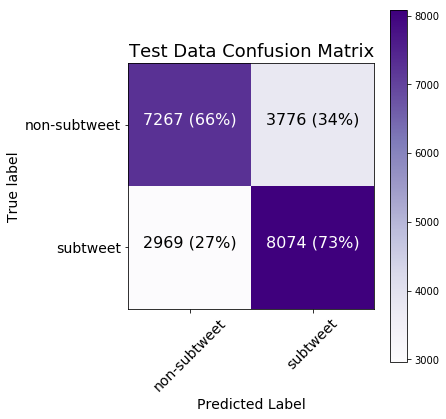

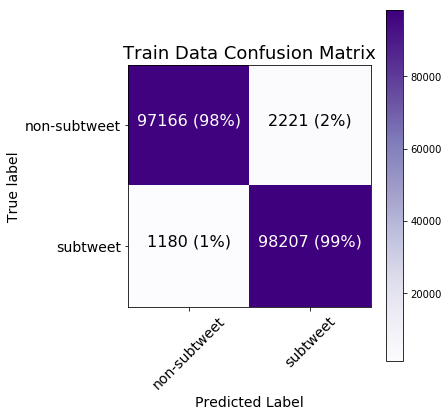

In [36]:
np.set_printoptions(precision=2)

plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix_test, title="Test Data Confusion Matrix")

plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix_train, title="Train Data Confusion Matrix")

plt.show()

#### Update matplotlib style

In [37]:
plt.style.use("fivethirtyeight")

#### Save the classifier for another time

In [38]:
joblib.dump(sentiment_pipeline, "../data/other_data/subtweets_classifier.pkl");

#### Print tests for the classifier

In [39]:
def process_tweets_for_testing(filenames):
    dataframes = {}
    for filename in filenames:
        username = splitext(basename(filename))[0][:-7]
        dataframes[username] = {}
        
        user_df = pd.read_csv(filename).dropna()
        user_df["Text"] = user_df["Text"].str.replace(hashtags_pattern, "➊")
        user_df["Text"] = user_df["Text"].str.replace(urls_pattern, "➋")
        user_df["Text"] = user_df["Text"].str.replace(at_mentions_pattern, "➌")
        user_df["Text"] = user_df["Text"].str.replace("\u2018", "'")
        user_df["Text"] = user_df["Text"].str.replace("\u2019", "'")
        user_df["Text"] = user_df["Text"].str.replace("\u201c", "\"")
        user_df["Text"] = user_df["Text"].str.replace("\u201d", "\"")
        user_df["Text"] = user_df["Text"].str.replace("&quot;", "\"")
        user_df["Text"] = user_df["Text"].str.replace("&amp;", "&")
        user_df["Text"] = user_df["Text"].str.replace("&gt;", ">")
        user_df["Text"] = user_df["Text"].str.replace("&lt;", "<")
        
        predictions = sentiment_pipeline.predict_proba(user_df["Text"])[:, 1].tolist()
        user_df["SubtweetProbability"] = predictions

        dataframes[username]["all"] = user_df
        
        scores = user_df[["SubtweetProbability"]].rename(columns={"SubtweetProbability": username})
        
        dataframes[username]["scores"] = scores
        dataframes[username]["stats"] = scores.describe()
        
    return dataframes

#### Load the CSV files

In [40]:
filenames = glob("../data/data_for_testing/friends_data/*.csv")

In [41]:
%%time
dataframes = process_tweets_for_testing(filenames)

CPU times: user 37 s, sys: 1.14 s, total: 38.2 s
Wall time: 43.3 s


#### Show a random table

In [42]:
chosen_username = choice(list(dataframes.keys()))
dataframes[chosen_username]["all"].sort_values(by="SubtweetProbability", ascending=False).head(5)

,Text,Date,Favorites,Retweets,Tweet ID,SubtweetProbability
43,Deep down I am very dumb and immature and it is very very exhausting to pretend otherwise all day gang,2018-02-19 21:48:33,24,2,965780184283668480,0.8174
481,"Twitter contrived to have people pretend to ""like"" you and now it reveals how many people could've pretended to like you but chose not to.",2015-11-11 15:56:31,0,0,664547274110967808,0.8151
163,"""What if Iago isn't a devilish mastermind, but just, like, a shitty dude? Like a petty, shitty dude?""- my bathetic pedagogy in a nutshell",2017-04-20 12:02:04,18,3,855089189423120384,0.8096
281,"Nobody understands my horrid jokes that obliquely allude to Hamlet but you, twitter",2016-08-19 18:35:18,3,0,766765509811572737,0.7991
91,"I keep coming up with ➊ dumb tweets, opening twitter to post them, reading half a sentence on my feed & then sighing until I pass out",2017-10-12 22:28:05,9,1,918664610152148992,0.7758


#### Prepare statistics on tweets

In [43]:
tests_df = pd.concat([df_dict["scores"] for df_dict in dataframes.values()], ignore_index=True)

In [44]:
test_df_stats = tests_df.describe()

In [45]:
test_df_stats.columns = ["User {}".format(i + 1) for i, column in enumerate(test_df_stats.columns)]

In [46]:
test_df_stats

,User 1,User 2,User 3,User 4,User 5,User 6,User 7,User 8,User 9,User 10,User 11,User 12,User 13,User 14
count,621.0000,2640.0000,2066.0000,3488.0000,4356.0000,1939.0000,1169.0000,638.0000,2814.0000,445.0000,772.0000,5364.0000,853.0000,1467.0000
mean,0.5026,0.5093,0.5420,0.5177,0.5076,0.4950,0.4349,0.5368,0.5052,0.4415,0.5291,0.4976,0.5337,0.5324
std,0.1094,0.1150,0.1162,0.1135,0.1065,0.1142,0.1005,0.1188,0.1112,0.0992,0.1195,0.1172,0.1181,0.1076
min,0.2086,0.1295,0.1312,0.1421,0.1546,0.0686,0.1349,0.1792,0.1612,0.1505,0.1019,0.0666,0.1593,0.1097
25%,0.4275,0.4325,0.4608,0.4432,0.4356,0.4257,0.3649,0.4606,0.4321,0.3764,0.4542,0.4208,0.4567,0.4645
50%,0.5027,0.5051,0.5393,0.5130,0.5064,0.5002,0.4360,0.5291,0.5023,0.4527,0.5260,0.5002,0.5391,0.5237
75%,0.5788,0.5837,0.6172,0.5958,0.5769,0.5641,0.5002,0.6159,0.5770,0.5012,0.6159,0.5729,0.6119,0.6035
max,0.8174,0.8920,0.8614,0.8925,0.9134,0.8826,0.8118,0.8732,0.8856,0.7538,0.8528,0.8881,0.8395,0.8502


#### Plot a histogram with three random users

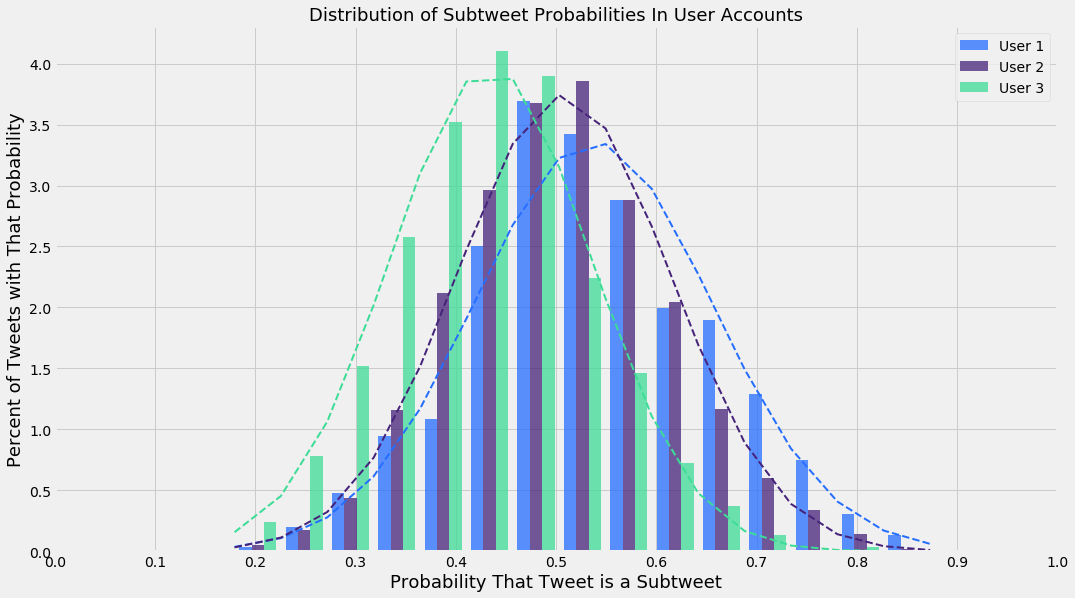

In [47]:
random_choices = sample(list(dataframes.values()), 3)
scores = [df_dict["scores"][df_dict["scores"].columns[0]].tolist() 
          for df_dict in random_choices]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(scores, 
                           bins="scott",
                           color=["#256EFF", "#46237A", "#3DDC97"],
                           density=True, 
                           label=["User 1", "User 2", "User 3"],
                           alpha=0.75)

stats = [df_dict["stats"][df_dict["stats"].columns[0]].tolist() 
         for df_dict in random_choices]

line_1 = scipy.stats.norm.pdf(bins, stats[0][1], stats[0][2])
ax.plot(bins, line_1, "--", color="#256EFF", linewidth=2)

line_2 = scipy.stats.norm.pdf(bins, stats[1][1], stats[1][2])
ax.plot(bins, line_2, "--", color="#46237A", linewidth=2)

line_3 = scipy.stats.norm.pdf(bins, stats[2][1], stats[2][2])
ax.plot(bins, line_3, "--", color="#3DDC97", linewidth=2)

ax.set_xticks([float(x/10) for x in range(11)], minor=False)
ax.set_title("Distribution of Subtweet Probabilities In User Accounts", fontsize=18)
ax.set_xlabel("Probability That Tweet is a Subtweet", fontsize=18)
ax.set_ylabel("Percent of Tweets with That Probability", fontsize=18)

ax.legend()

plt.show()

#### Plot a histogram with all of them
#### First, get some statistics

In [48]:
new_tests_df = pd.concat([df_dict["scores"].rename(columns={df_dict["scores"].columns[0]:"SubtweetProbability"})
                          for df_dict in dataframes.values()], ignore_index=True)

new_tests_df_stats = new_tests_df.describe()

#### Then view them

In [49]:
new_tests_df_stats

,SubtweetProbability
count,28632.0000
mean,0.5077
std,0.1148
min,0.0666
25%,0.4316
50%,0.5031
75%,0.5825
max,0.9134


#### Now plot

No handles with labels found to put in legend.


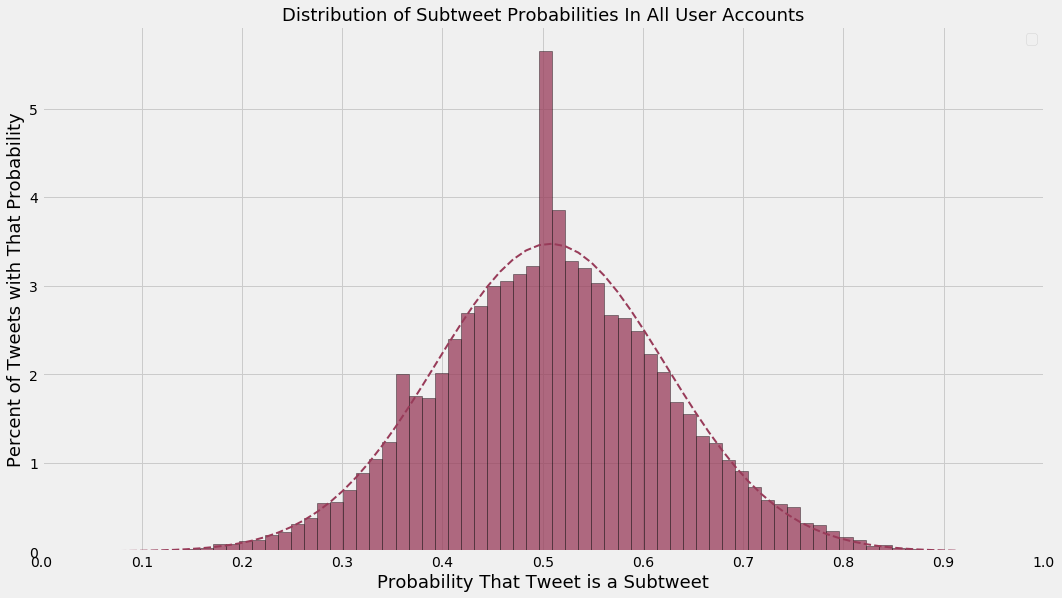

In [50]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(new_tests_df["SubtweetProbability"].tolist(), 
                           bins="scott",
                           color="#983B59",
                           edgecolor="black", 
                           density=True, 
                           alpha=0.75)

line = scipy.stats.norm.pdf(bins, new_tests_df_stats["SubtweetProbability"][1], 
                              new_tests_df_stats["SubtweetProbability"][2])

ax.plot(bins, line, "--", color="#983B59", linewidth=2)


ax.set_xticks([float(x/10) for x in range(11)], minor=False)
ax.set_title("Distribution of Subtweet Probabilities In All User Accounts", fontsize=18)
ax.set_xlabel("Probability That Tweet is a Subtweet", fontsize=18)
ax.set_ylabel("Percent of Tweets with That Probability", fontsize=18)

ax.legend()

plt.show()

#### Statisitics on training data

#### Remove mentions of usernames for these statistics

In [51]:
training_data = [(tweet[0]
                  .replace("➊", "")
                  .replace("➋", "")
                  .replace("➌", "")) for tweet in training_data]

#### Lengths

In [52]:
length_data = [len(tweet) for tweet in training_data]

In [53]:
length_data_for_stats = pd.DataFrame({"Length": length_data, "Tweet": training_data})

In [54]:
# length_data_for_stats = length_data_for_stats[length_data_for_stats["Length"] <= 280]  

In [55]:
# length_data_for_stats = length_data_for_stats[length_data_for_stats["Length"] >= 5]

In [56]:
length_data = length_data_for_stats.Length.tolist()

#### Top 5 longest tweets

In [57]:
length_data_for_stats.sort_values(by="Length", ascending=False).head()

,Length,Tweet
8546,281,"Being a good person can never be overrated because you don't do it for people, you do it for yourself. Being a good person means making choices that correspond with your beliefs. It's the energy you put out & exude. You will not be your true self if you tried to be anything else."
1894,281,"Hello everyone\n\nThis is probably going to be my biggest tweet for months also no I'm not going to personally answer everyone's questions\n\nTo summarize though:\n\nPlenty of people found the interview without help, that's not how gender works, that's not how gender works, that's not-"
1621,281,"ok so im part of several astro facebook groups as yall know and we all just made our versions of this alignment chart for the signs, here's mine and the blank copy reply with urs!!!! this is 100% for fun and i don't think any signs or placements are actually cursed or blessed etc"
8087,281,"I was just on KFAN talking about, among many other things, Twins games being canceled by snow and how extreme weather across the country has caused other MLB teams to cancel games as well. By the time I got to my car to drive home from the station, this e-mail was waiting for me."
19769,281,Aurora: American white man\nOrlando: American white man\nParkland: American white man\nLas Vegas: American white man\nSandy Hook: American white man\nUmpqua CC: American white man\nWaffle House: American White man\nTexas Church: American white man\nIf only there were some commonality....


#### Top 5 shortest tweets

In [58]:
length_data_for_stats.sort_values(by="Length", ascending=True).head()

,Length,Tweet
10197,1,.
8202,1,A
16074,1,C
9185,2,Ha
15591,2,hi


#### Tweet length statistics

In [59]:
length_data_for_stats.describe()

,Length
count,22086.0000
mean,105.1392
std,72.9007
min,1.0000
25%,48.0000
50%,85.0000
75%,147.0000
max,281.0000


#### Punctuation

In [60]:
punctuation_data = [len(set(punctuation).intersection(set(tweet))) for tweet in training_data]

In [61]:
punctuation_data_for_stats = pd.DataFrame({"Punctuation": punctuation_data, "Tweet": training_data})

#### Top 5 most punctuated tweets

In [62]:
punctuation_data_for_stats.sort_values(by="Punctuation", ascending=False).head()

,Punctuation,Tweet
11957,11,"Going to go ahead and crown myself the absolute emperor of finding things on menus that sound interesting, deciding I would like to try them, then being told ""I'm sorry sir, that's actually not available...""\n\n[ then why the @#$% is it ON YOUR MENUUUUUUUU-- ]"
16717,10,"Hooray—for those of you who've been asking when FLASHBACK will be available for pre-order on *ebook* the answer is finally: NOW! Alas, pre-ordering won't make it come out sooner than 11/6 (still writing it, guys). BUT, it does make me super happy, so… 😉\n"
17285,10,I created an equation to find the largest meaningful number in the observable universe.\n\nVolume Quantitative Infinity [vQ(inf)]= (4/3)(pi)ct^3\n\nI'll explain it in a thread. (1/?)
8841,9,"Old, out-of-touch nominally liberal guy: ""Well, some of you won't appreciate my courage, but I've got some hard truths to share!""\n\n*Nazis and predators praise him*\n\n""See? This shows that I am wise and insightful."""
1696,9,"happy 4/20, every time i get high i assume that i've peed my pants and everyone hates me but i'm happy it works for other people!! (do not @ me with ""have you tried indica instead of sativa?"" or vice versa i'm a jersey gutter rat toots i've tried it all)"


#### Tweets punctuation statistics

In [63]:
punctuation_data_for_stats.describe()

,Punctuation
count,22086.0000
mean,1.8969
std,1.5640
min,0.0000
25%,1.0000
50%,2.0000
75%,3.0000
max,11.0000


#### Stop words

In [64]:
stop_words_data = [len(set(stopwords.words("english")).intersection(set(tweet.lower()))) 
                   for tweet in training_data]

In [65]:
stop_words_data_for_stats = pd.DataFrame({"Stop words": stop_words_data, "Tweet": training_data})

#### Top 5 tweets with most stop words

In [66]:
stop_words_data_for_stats.sort_values(by="Stop words", ascending=False).head()

,Stop words,Tweet
0,8,"I try my best to have plenty of buffer, but we still have bursts of income (since deals are annual or on production cycles, not monthly), and 1-2 times a year are really stressful because I'm counting on a big influx of cash and never know if [big corp] will decide to pay on time"
12597,8,| Since I've filed the complaint the MLA's family had been threatening my family. They keep calling. We've left our house. We're living in a hotel. Till when will we live in a hotel? When will we get justice?: Unnao rape victim's uncle
12574,8,"""A person who deserves my loyalty receives it.""- Joyce Maynard I will always protect our \n\n"
12576,8,If social drinking on foreign presidential trips is now grounds for ruthless character assassination then I encourage media outlets to reach out to me so I can fill them in on all of the Obama staffers who downed alcohol by the barrel overseas.
12577,8,",,, does my header & icon match bc if they do omG"


#### Top 5 tweets with fewest stop words

In [67]:
stop_words_data_for_stats.sort_values(by="Stop words", ascending=True).head()

,Stop words,Tweet
10730,0,fuck u
18456,0,R&b
1919,0,Uh
10212,0,fuck
2038,0,Clever.


#### Tweets stop words statistics

In [68]:
stop_words_data_for_stats.describe()

,Stop words
count,22086.0000
mean,7.1418
std,1.3155
min,0.0000
25%,7.0000
50%,8.0000
75%,8.0000
max,8.0000


#### Unique words

In [69]:
unique_words_data = [len(set(tokenizer.tokenize(tweet))) for tweet in training_data]

In [70]:
unique_words_data_for_stats = pd.DataFrame({"Unique words": unique_words_data, "Tweet": training_data})

In [71]:
# unique_words_data_for_stats = unique_words_data_for_stats[unique_words_data_for_stats["Unique words"] >= 2]

In [72]:
unique_words_data = unique_words_data_for_stats["Unique words"].tolist()

#### Top 5 tweets with most unique words

In [73]:
unique_words_data_for_stats.sort_values(by="Unique words", ascending=False).head()

,Tweet,Unique words
2338,"I'm starting to get a couple questions about it since May is coming up so I might as well let you guys know: there will not be a MIAMAFV 2 this year (at least not that exact event).\n\nWho knows what's to come in the future, but right now I've got to take care of other stuff first.",59
14241,"GIVE AWAY!\n\nThe rules are really easy, all you have to do is :\n1. Must be following me (i check) \n2. RT and fav this tweet\n3. tag your mutuals/anyone\n4. only 1 winner! \n5. i ship worldwide;) \n\nit ends in 8th May 2018 or when this tweet hit 2k RT and like!\n\nGood luck! ❤",59
19761,"ur bday 21/8 u50. Fancy a kick about the park where we used to play.?Jumpers down- shots.Then 3 holes of golf.we hit any windows we run!What do u say- will be a laugh.I am 50 a week later.hey, we're still kind of fit:))give me a shout if up 4 it 07532203285 Liam",58
9101,"got into a tepid back nd forth w/ a uknowwhoAJ+columnist bc i said they steal their ""hot takes"" from blk twitter & alike. wallahi my bdeshi ass did not sign up 4 this app to be called asinine by a 30yrold pakistani whos whole politics is Post Colonial Memes for Oriental Minded T-",57
8077,"Crazy how wrong u can be about someone. A girl I graduated w/ was always doing drugs& got pregnant at 16. I assumed she'd end up being a loser but it turn out she now has 4 beautiful kids& is making over $4,500/month just off of child support payments from the 3 different dads",57


#### Top 5 tweets with fewest unique words

In [74]:
unique_words_data_for_stats.sort_values(by="Unique words", ascending=True).head()

,Tweet,Unique words
19687,Ugh,1
6169,ME,1
1445,no,1
8543,Drive Drive Drive Drive Drive,1
6479,Discuss,1


#### Tweets unique words statistics

In [75]:
unique_words_data_for_stats.describe()

,Unique words
count,22086.0000
mean,19.0280
std,11.8226
min,1.0000
25%,10.0000
50%,16.0000
75%,26.0000
max,59.0000


#### Plot them

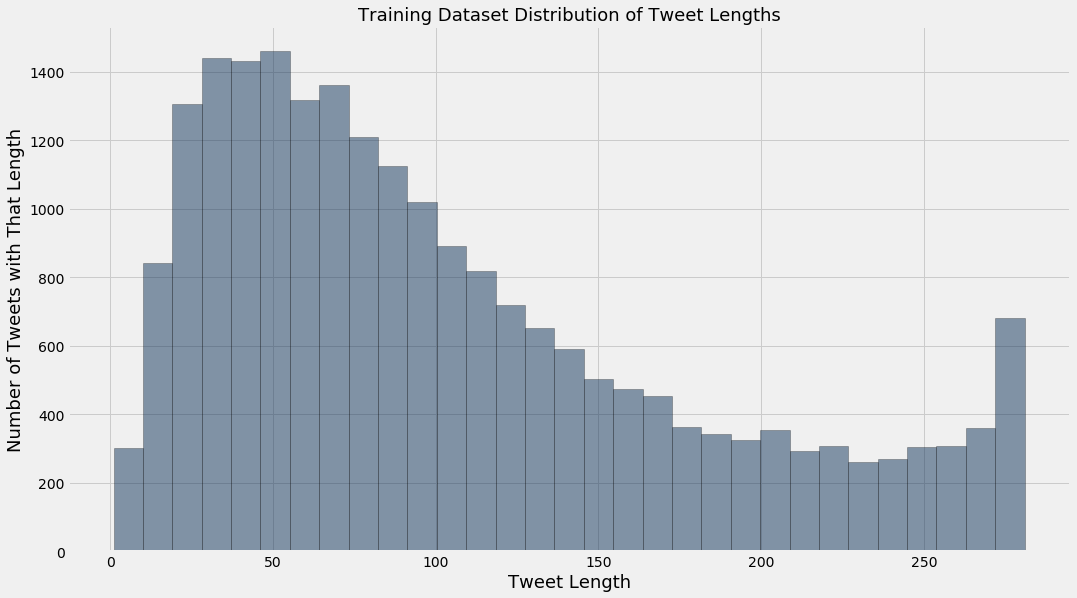

In [76]:
length_mean = length_data_for_stats.describe().Length[1]
length_std = length_data_for_stats.describe().Length[2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(length_data, 
                           bins="scott", 
                           edgecolor="black", 
                           # density=True, 
                           color="#12355b", 
                           alpha=0.5)

# length_line = scipy.stats.norm.pdf(bins, length_mean, length_std)
# ax.plot(bins, length_line, "--", linewidth=3, color="#415d7b")

ax.set_title("Training Dataset Distribution of Tweet Lengths", fontsize=18)
ax.set_xlabel("Tweet Length", fontsize=18);
ax.set_ylabel("Number of Tweets with That Length", fontsize=18);

plt.show()

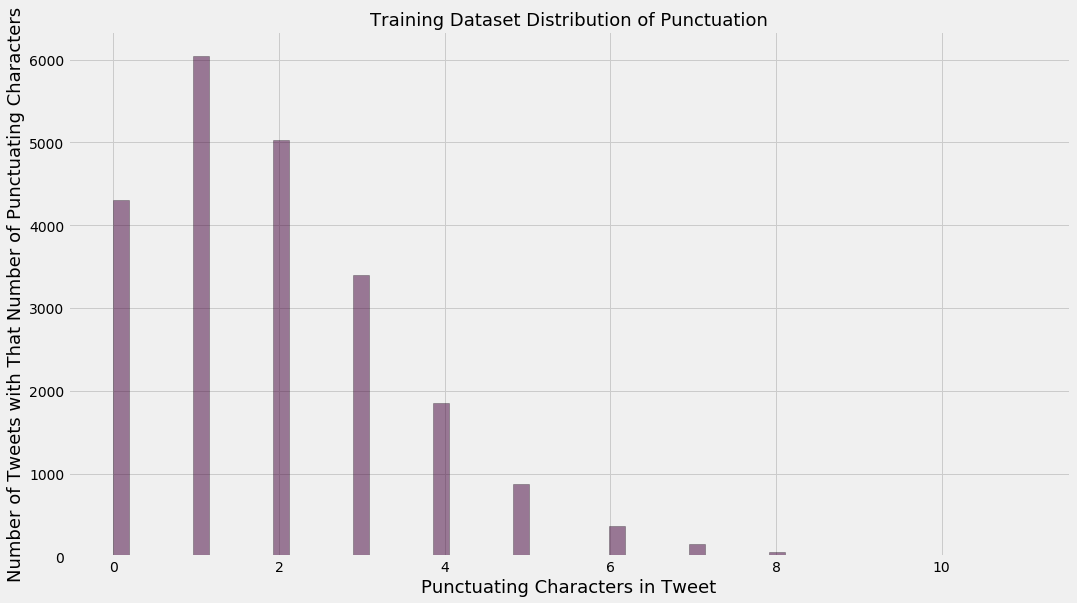

In [77]:
punctuation_mean = punctuation_data_for_stats.describe().Punctuation[1]
punctuation_std = punctuation_data_for_stats.describe().Punctuation[2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(punctuation_data, 
                           bins="scott",
                           edgecolor="black", 
                           # density=True, 
                           color="#420039",
                           alpha=0.5)

# punctution_line = scipy.stats.norm.pdf(bins, punctuation_mean, punctuation_std)
# ax.plot(bins, punctution_line, "--", linewidth=3, color="#673260")

ax.set_title("Training Dataset Distribution of Punctuation", fontsize=18)
ax.set_xlabel("Punctuating Characters in Tweet", fontsize=18)
ax.set_ylabel("Number of Tweets with That Number of Punctuating Characters", fontsize=18)

plt.show()

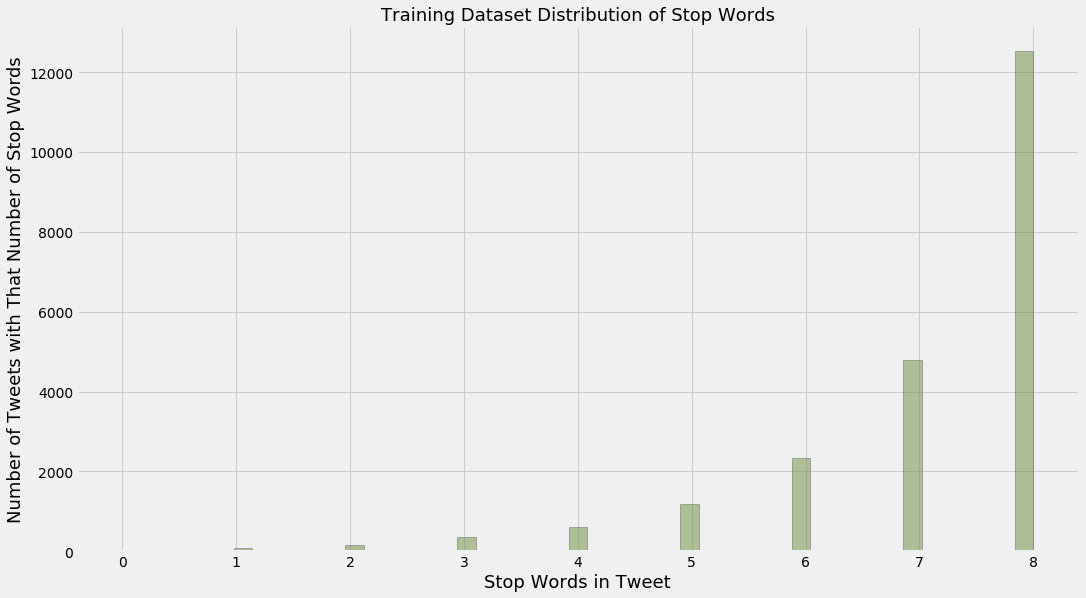

In [78]:
stop_words_mean = stop_words_data_for_stats.describe()["Stop words"][1]
stop_words_std = stop_words_data_for_stats.describe()["Stop words"][2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(stop_words_data, 
                           bins="scott", 
                           edgecolor="black", 
                           # density=True, 
                           color="#698f3f",
                           alpha=0.5)

# stop_words_line = scipy.stats.norm.pdf(bins, stop_words_mean, stop_words_std)
# ax.plot(bins, stop_words_line, "--", linewidth=3, color="#87a565")

ax.set_title("Training Dataset Distribution of Stop Words", fontsize=18)
ax.set_xlabel("Stop Words in Tweet", fontsize=18)
ax.set_ylabel("Number of Tweets with That Number of Stop Words", fontsize=18)

plt.show()

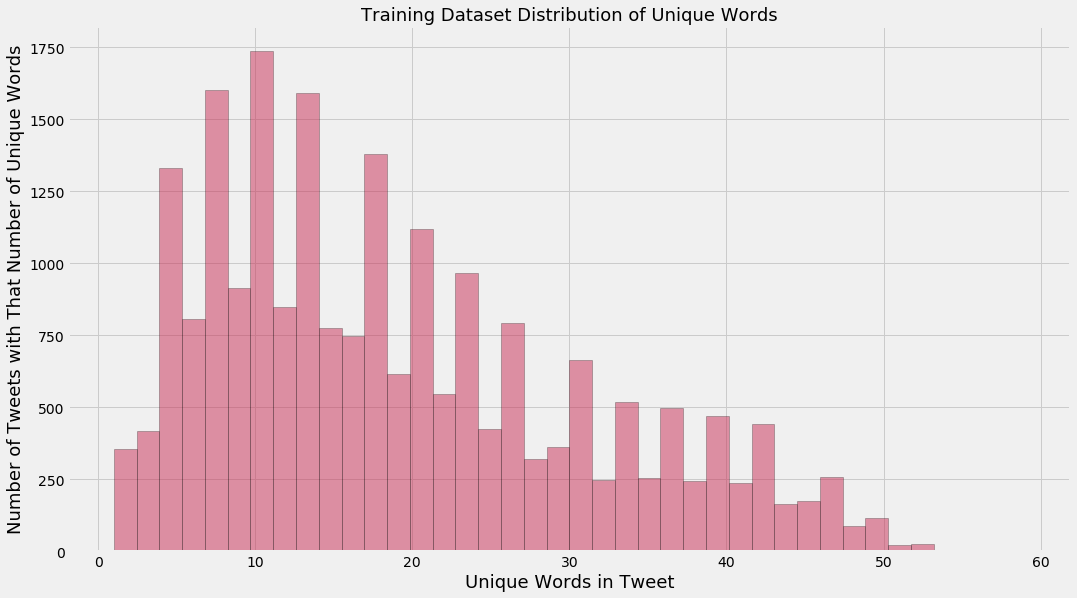

In [79]:
unique_words_mean = unique_words_data_for_stats.describe()["Unique words"][1]
unique_words_std = unique_words_data_for_stats.describe()["Unique words"][2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(unique_words_data, 
                           bins="scott", 
                           edgecolor="black", 
                           # density=True, 
                           color="#ca2e55",
                           alpha=0.5)

# unique_words_line = scipy.stats.norm.pdf(bins, unique_words_mean, unique_words_std)
# ax.plot(bins, unique_words_line, "--", linewidth=3, color="#d45776")

ax.set_title("Training Dataset Distribution of Unique Words", fontsize=18)
ax.set_xlabel("Unique Words in Tweet", fontsize=18)
ax.set_ylabel("Number of Tweets with That Number of Unique Words", fontsize=18)

plt.show()